In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

import seaborn as sns
# import colorcet as cc
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
import pickle

# Func

In [5]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        # meta = meta.head(1) # multisession, only keep one metadata
    return meta


def df_adp_mag(adp_mag, dfof_ad, dfof_tg):
    mag = adp_mag.flatten('F')
    ad = dfof_ad.flatten('F')
    tg = dfof_tg.flatten('F')

    cell_num = [np.arange(adp_mag.shape[0])] * adp_mag.shape[1]
    cell_num = np.concatenate(cell_num)
    stim = [np.arange(nstim)] * adp_mag.shape[0]
    stim_flat = np.sort([item for sublist in stim for item in sublist])
    
    df = pd.DataFrame({'cell':cell_num ,'stim':stim_flat, 'ad':ad, 'tg':tg, 'mag':mag, 'abs_mag':np.abs(mag)})
    return stim_flat, mag, ad, df


def threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=10): 
    '''no threshold for dfof_ad bc too few shared stim for side A/B'''
    df_th = df.copy()
    # df_th.loc[df_th[(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan # not threshold by abs, bc 1-tail ttest originally
    df_th.loc[df_th[np.abs(df.mag) > adp_threshold].index.to_numpy(),'mag'] = np.nan # bug / todo: fix vis_ad and filter normally by vis_ad, not filter by adp_mag
    
    mag_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
    mag_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
    mag_std = df_th[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
    mag_sem = df_th[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
    return df_th, mag_mean, mag_median, mag_std, mag_sem

    
def mean_confidence_interval(data, confidence=0.95): # find 95% CI among iterations
    a = 1.0 * np.array(data)
    n = a.shape[0]
    m = np.nanmean(a, axis=0)
    se = stats.sem(a, axis=0, nan_policy='omit')
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [6]:
niter = 100
def split_correlate_side(mode, niter=50):

    dfof_ad_side_both = np.empty((ncell, nstim))
    dfof_ad_sideA = np.empty((ncell, nstim))
    dfof_ad_sideB = np.empty((ncell, nstim))
    dfof_tg_sideA = np.empty((ncell, nstim))
    dfof_tg_sideB = np.empty((ncell, nstim))

    # niter = 50 # 9 min 100 iter, 6 min 50 iter, 1 min 10 iter
    corr_pearson_iter = np.zeros((1, ncell))
    p_pearson_iter = np.zeros((1, ncell))
    corr_spearman_iter = np.zeros((1, ncell))
    nstim_shared_iter = np.zeros((1, ncell))

    for i in tqdm(np.arange(niter)):
        for icell in np.arange(ncell):
            for istim in np.arange(nstim):
                ntrial_cond = dfof_ad_trial[icell,istim].shape[0]
                dfof_ad_side_both[icell,istim] = np.mean(dfof_ad_trial[icell,istim])

                idx_trial = np.random.choice(np.arange(ntrial_cond), size=ntrial_cond//2, replace=False)
                dfof_ad_sideA[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial,:])
                dfof_tg_sideA[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial,:])

                idx_trial_diff = np.setdiff1d(np.arange(ntrial_cond), idx_trial)
                dfof_ad_sideB[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial_diff,:])
                dfof_tg_sideB[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial_diff,:])

        if mode == 'adp':
            adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_ad_sideA + 1e-7) # (R2-R1)/(R1+epsilon)
            adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_ad_sideB + 1e-7)
        elif mode == 'adp_alt':
            adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_tg_sideA + dfof_ad_sideA + 1e-7) # (R2-R1)/(R1+R2) to reduce R1 effect
            adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_tg_sideB + dfof_ad_sideB + 1e-7)
        elif mode == 'adp_stable':
            adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_ad_side_both + 1e-7) # R1 denominator should be stable, so use both sides
            adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_ad_side_both + 1e-7)
        elif mode == 'ad':
            adp_sideA = dfof_ad_sideA # grating tg noad is like bunnytop ad: 8 orientations, unadapted
            adp_sideB = dfof_ad_sideB
        elif mode == 'tg':
            adp_sideA = dfof_tg_sideA # grating tg is like bunnytop tg: 8 orientations, adapted
            adp_sideB = dfof_tg_sideB

        _, _, _, df_sideA = df_adp_mag(adp_sideA, dfof_ad_sideA, dfof_tg_sideA)
        _, _, _, df_sideB = df_adp_mag(adp_sideB, dfof_ad_sideB, dfof_tg_sideB)

        corr_pearson_pop = []
        p_pearson_pop = []
        corr_spearman_pop = []
        nstim_shared = []

        for icell in np.arange(ncell):
            df_sideA_cell = df_sideA.loc[df_sideA['cell'] == icell]
            df_sideB_cell = df_sideB.loc[df_sideB['cell'] == icell]
            _, mag_mean_sideA_cell, mag_median_sideA_cell, _, _ = threshold_adp_mag(df_sideA_cell, dfof_threshold=0, adp_threshold=500) # dfof thresh = 0 bc already vis driven
            _, mag_mean_sideB_cell, mag_median_sideB_cell, _, _ = threshold_adp_mag(df_sideB_cell, dfof_threshold=0, adp_threshold=500)

            mag_mean_sideA_cell = mag_median_sideA_cell # try use median instead of mean to reduce effect of outliers
            mag_mean_sideB_cell = mag_median_sideB_cell # TODO: properly assign intermediate var to choose between mean or median

            not_nan_mask = (~np.isnan(mag_mean_sideA_cell)) & (~np.isnan(mag_mean_sideB_cell))
            nstim_shared.append(sum(not_nan_mask))

            try:
                corr_pearson_cell, p_pearson_cell = stats.pearsonr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask])
                corr_spearman_cell, _ = stats.spearmanr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask]) # spearman p is only "probably reasonable for datasets larger than 500"
            except ValueError: # not enough shared stim to calc corr
                corr_pearson_cell = np.nan
                p_pearson_cell = np.nan
                corr_spearman_cell = np.nan
            corr_pearson_pop.append(corr_pearson_cell)
            p_pearson_pop.append(p_pearson_cell)
            corr_spearman_pop.append(corr_spearman_cell)
            
        nstim_shared_iter = np.vstack((nstim_shared_iter, nstim_shared))
        corr_pearson_iter = np.vstack((corr_pearson_iter, corr_pearson_pop))
        p_pearson_iter = np.vstack((p_pearson_iter, p_pearson_pop))
        corr_spearman_iter = np.vstack((corr_spearman_iter, corr_spearman_pop))

    vis_driven_mask = np.array(vis_driven_bool).astype(float).flatten() # apply vis driven mask -> non-vis cells = nan
    vis_driven_mask[vis_driven_mask==0] = np.nan
    
    # any_img_driven = np.sum(img_driven, axis=1)
    # any_img_driven = (any_img_driven>0).astype(float)
    # any_img_driven[any_img_driven==0] = np.nan
    # vis_driven_mask = any_img_driven

    nstim_shared_iter = nstim_shared_iter[1:,:] * vis_driven_mask # remove the first row of zeros
    corr_pearson_iter = corr_pearson_iter[1:,:] * vis_driven_mask
    p_pearson_iter = p_pearson_iter[1:,:] * vis_driven_mask
    corr_spearman_iter = corr_spearman_iter[1:,:] * vis_driven_mask

    return nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter#, df_sideA

In [69]:
niter = 1
def split_correlate_side_peek_cell(mode, peek_cell_id, niter=1):

    dfof_ad_side_both = np.empty((ncell, nstim))
    dfof_ad_sideA = np.empty((ncell, nstim))
    dfof_ad_sideB = np.empty((ncell, nstim))
    dfof_tg_sideA = np.empty((ncell, nstim))
    dfof_tg_sideB = np.empty((ncell, nstim))

    # corr_spearman_iter = np.zeros((1, ncell))
    # nstim_shared_iter = np.zeros((1, ncell))

    for i in tqdm(np.arange(niter)):
        for icell in np.arange(ncell):
            for istim in np.arange(nstim):
                ntrial_cond = dfof_ad_trial[icell,istim].shape[0]
                dfof_ad_side_both[icell,istim] = np.mean(dfof_ad_trial[icell,istim])

                idx_trial = np.random.choice(np.arange(ntrial_cond), size=ntrial_cond//2, replace=False)
                dfof_ad_sideA[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial,:])
                dfof_tg_sideA[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial,:])

                idx_trial_diff = np.setdiff1d(np.arange(ntrial_cond), idx_trial)
                dfof_ad_sideB[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial_diff,:])
                dfof_tg_sideB[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial_diff,:])

        if mode == 'adp_alt':
            adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_tg_sideA + dfof_ad_sideA + 1e-7) # (R2-R1)/(R1+R2) to reduce R1 effect
            adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_tg_sideB + dfof_ad_sideB + 1e-7)
        elif mode == 'ad':
            adp_sideA = dfof_ad_sideA # grating tg noad is like bunnytop ad: 8 orientations, unadapted
            adp_sideB = dfof_ad_sideB
        elif mode == 'tg':
            adp_sideA = dfof_tg_sideA # grating tg is like bunnytop tg: 8 orientations, adapted
            adp_sideB = dfof_tg_sideB

        _, _, _, df_sideA = df_adp_mag(adp_sideA, dfof_ad_sideA, dfof_tg_sideA)
        _, _, _, df_sideB = df_adp_mag(adp_sideB, dfof_ad_sideB, dfof_tg_sideB)

        corr_spearman_pop = []
        nstim_shared = []
        adp_agg_sideA_pop = []
        adp_agg_sideB_pop = []

        for icell in peek_cell_id:
            df_sideA_cell = df_sideA.loc[df_sideA['cell'] == icell]
            df_sideB_cell = df_sideB.loc[df_sideB['cell'] == icell]

            _, mag_mean_sideA_cell, mag_median_sideA_cell, _, _ = threshold_adp_mag(df_sideA_cell, dfof_threshold=0, adp_threshold=6) # dfof thresh = 0 bc already vis driven
            _, mag_mean_sideB_cell, mag_median_sideB_cell, _, _ = threshold_adp_mag(df_sideB_cell, dfof_threshold=0, adp_threshold=6)

            adp_agg_sideA_cell = mag_median_sideA_cell # try use median instead of mean to reduce effect of outliers
            adp_agg_sideB_cell = mag_median_sideB_cell # TODO: properly assign intermediate var to choose between mean or median

            not_nan_mask = (~np.isnan(adp_agg_sideA_cell)) & (~np.isnan(adp_agg_sideB_cell))
            nstim_shared.append(sum(not_nan_mask))

            try:
                corr_spearman_cell, _ = stats.spearmanr(adp_agg_sideA_cell[not_nan_mask], adp_agg_sideB_cell[not_nan_mask]) # spearman p is only "probably reasonable for datasets larger than 500"
                adp_agg_sideA_pop.append(adp_agg_sideA_cell[not_nan_mask])
                adp_agg_sideB_pop.append(adp_agg_sideB_cell[not_nan_mask])
            except ValueError: # not enough shared stim to calc corr
                corr_spearman_cell = np.nan
            corr_spearman_pop.append(corr_spearman_cell)
            
        # nstim_shared_iter = np.vstack((nstim_shared_iter, nstim_shared))
        # corr_spearman_iter = np.vstack((corr_spearman_iter, corr_spearman_pop))

    # vis_driven_mask = np.array(vis_driven_bool).astype(float).flatten() # apply vis driven mask -> non-vis cells = nan
    # vis_driven_mask[vis_driven_mask==0] = np.nan

    # nstim_shared_iter = nstim_shared_iter[1:,:] * vis_driven_mask # remove the first row of zeros
    # corr_spearman_iter = corr_spearman_iter[1:,:] * vis_driven_mask

    return adp_agg_sideA_pop, adp_agg_sideB_pop, corr_spearman_pop

In [7]:
# # use cells img driven by >=2 imgs only
# def split_correlate_side_img_driv(mode, niter=50):

#     dfof_ad_side_both = np.empty((ncell, nstim))
#     dfof_ad_sideA = np.empty((ncell, nstim))
#     dfof_ad_sideB = np.empty((ncell, nstim))
#     dfof_tg_sideA = np.empty((ncell, nstim))
#     dfof_tg_sideB = np.empty((ncell, nstim))

#     # niter = 50 # 9 min 100 iter, 6 min 50 iter, 1 min 10 iter
#     corr_pearson_iter = np.zeros((1, ncell))
#     p_pearson_iter = np.zeros((1, ncell))
#     corr_spearman_iter = np.zeros((1, ncell))
#     nstim_shared_iter = np.zeros((1, ncell))

#     for i in tqdm(np.arange(niter)):
#         for icell in np.arange(ncell):
#             for istim in np.arange(nstim):

#                 if ~img_driven2[icell] | (img_driven[icell, istim] == 0): # if not img driven or img driven by 1 img
#                     dfof_ad_sideA[icell, istim] = np.nan
#                     dfof_ad_sideB[icell, istim] = np.nan
#                     dfof_tg_sideA[icell, istim] = np.nan
#                     dfof_tg_sideB[icell, istim] = np.nan
#                 else:
#                     ntrial_cond = dfof_ad_trial[icell,istim].shape[0]
#                     idx_trial = np.random.choice(np.arange(ntrial_cond), size=ntrial_cond//2, replace=False)
#                     dfof_ad_sideA[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial,:])
#                     dfof_tg_sideA[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial,:])

#                     idx_trial_diff = np.setdiff1d(np.arange(ntrial_cond), idx_trial)
#                     dfof_ad_sideB[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial_diff,:])
#                     dfof_tg_sideB[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial_diff,:])

#         if mode == 'adp':
#             adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_ad_sideA + 1e-7) # (R2-R1)/(R1+epsilon)
#             adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_ad_sideB + 1e-7)
#         elif mode == 'adp_alt':
#             adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_tg_sideA + dfof_ad_sideA + 1e-7) # (R2-R1)/(R1+R2) to reduce R1 effect
#             adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_tg_sideB + dfof_ad_sideB + 1e-7)
#         elif mode == 'ad':
#             adp_sideA = dfof_ad_sideA # grating tg noad is like bunnytop ad: 8 orientations, unadapted
#             adp_sideB = dfof_ad_sideB
#         elif mode == 'tg':
#             adp_sideA = dfof_tg_sideA # grating tg is like bunnytop tg: 8 orientations, adapted
#             adp_sideB = dfof_tg_sideB

#         _, _, _, df_sideA = df_adp_mag(adp_sideA, dfof_ad_sideA, dfof_tg_sideA)
#         _, _, _, df_sideB = df_adp_mag(adp_sideB, dfof_ad_sideB, dfof_tg_sideB)

#         corr_pearson_pop = []
#         p_pearson_pop = []
#         corr_spearman_pop = []
#         nstim_shared = []

#         for icell in np.arange(ncell):
#             df_sideA_cell = df_sideA.loc[df_sideA['cell'] == icell]
#             df_sideB_cell = df_sideB.loc[df_sideB['cell'] == icell]
#             _, mag_mean_sideA_cell, _, _, _ = threshold_adp_mag(df_sideA_cell, dfof_threshold=0, adp_threshold=10) # dfof thresh = 0 bc already vis driven
#             _, mag_mean_sideB_cell, _, _, _ = threshold_adp_mag(df_sideB_cell, dfof_threshold=0, adp_threshold=10)

#             not_nan_mask = (~np.isnan(mag_mean_sideA_cell)) & (~np.isnan(mag_mean_sideB_cell))
#             nstim_shared.append(sum(not_nan_mask))

#             if sum(not_nan_mask) >= 2:
#                 corr_pearson_cell, p_pearson_cell = stats.pearsonr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask])
#                 corr_spearman_cell, _ = stats.spearmanr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask]) # spearman p is only "probably reasonable for datasets larger than 500"
#             else:
#                 corr_pearson_cell = np.nan
#                 p_pearson_cell = np.nan
#                 corr_spearman_cell = np.nan
#             corr_pearson_pop.append(corr_pearson_cell)
#             p_pearson_pop.append(p_pearson_cell)
#             corr_spearman_pop.append(corr_spearman_cell)
            
#         nstim_shared_iter = np.vstack((nstim_shared_iter, nstim_shared))
#         corr_pearson_iter = np.vstack((corr_pearson_iter, corr_pearson_pop))
#         p_pearson_iter = np.vstack((p_pearson_iter, p_pearson_pop))
#         corr_spearman_iter = np.vstack((corr_spearman_iter, corr_spearman_pop))

#     vis_driven_mask = vis_driven.copy().astype(float).flatten() # apply vis driven mask -> non-vis cells = nan
#     # vis_driven_mask[vis_driven_mask==0] = np.nan
#     vis_driven_mask = np.ones(vis_driven_mask.shape) # use img driven mask, not vis driven mask
#     nstim_shared_iter = nstim_shared_iter[1:,:] * vis_driven_mask # remove the first row of zeros
#     corr_pearson_iter = corr_pearson_iter[1:,:] * vis_driven_mask
#     p_pearson_iter = p_pearson_iter[1:,:] * vis_driven_mask
#     corr_spearman_iter = corr_spearman_iter[1:,:] * vis_driven_mask

#     return nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter#, mag_mean_sideA_cell

# Load

In [8]:
# root_path = 'C:/Users/ll357/Documents/inter/data/'
# root_path = r'C:\Users\GlickfeldLab\Documents\test\inter/'.replace('\\', '/')
root_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
meta = load_metadata(root_path, paradigm_setting='bunnytop high res', session_num='')
print(meta)

meta = meta.iloc[2].to_frame().T.reset_index()
# meta.date = meta.date.str.split('_').str[0]; print('manual segment!')
meta.date = meta.date.str.split('_').str[0] + '_cellpose'; print('cellpose segment!')
print(meta)

   mouse           date area  num
0   1350  220225_caiman   V1  2.0
1   1350  220225_caiman   V1  3.0
2   1369  220310_caiman   V1  2.0
3   1369  220310_caiman   V1  3.0
4   1369  220311_caiman   LM  2.0
5   1369  220311_caiman   LM  3.0
cellpose segment!
   index mouse             date area  num
0      2  1369  220310_cellpose   V1  2.0


In [9]:
# dir_name = root_path + 'mat/'
iset = 0
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

dfof_trialwise = scipy.io.loadmat(os.path.join(root_path, dir_sub, 'resp_base_trialwise' + '.mat'))
# dfof_trialwise.keys(), dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape

dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] - dfof_trialwise['dfof_base_trial'] # should subtract baseline!
dfof_tg_trial = dfof_trialwise['dfof_tg_trial'] - dfof_trialwise['dfof_base2_trial']

ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]
print(f'{ncell} cells, {nstim} stimuli')

with open(os.path.join(root_path, dir_sub,'vis_driven.pickle'), 'rb') as f:
    # img_driven = pickle.load(f)
    vis_driven = pickle.load(f)
# print(vis_driven.keys())

vis_driven_bool = vis_driven['vis_driven']
vis_driven_bool = [v[0] for v in vis_driven_bool]
# vis_driven_bool

114 cells, 30 stimuli


# vis driven criteria test

## threshold evoked

-0.4388307776074054

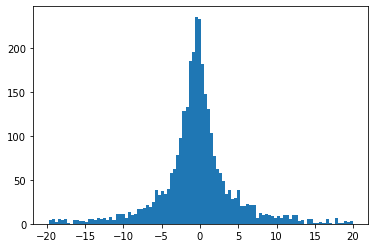

In [28]:
# evoked = vis_driven['evoked']
# evoked_flat = evoked.flatten()
# plt.hist(evoked_flat[np.abs(evoked_flat) < 20], 100);
# np.median(evoked_flat) # TODO: why is evoked median negative for caiman and cellpose??? 
# # for manual, it's 0.01. for caiman, it's -0.6, for cellpose, it's -0.44

In [12]:
# # vis driven cells defined by only evoked resp:
# evoked_sig = 10

# # visually driven loose: pass amp threshold for >=1 image
# vis_driven = (sum(evoked.T > evoked_sig) > 0).reshape(-1, 1)
# print(f'{vis_driven.sum()} cells are visually driven, \n\
#     proportion {np.round(vis_driven.sum()/ncell, 2)} out of {ncell} cells')

# # cells responsive to image i loose: pass visually driven AND amp threshold for *this* image
# img_driven = vis_driven & (evoked > evoked_sig)
# print(f'{img_driven.sum()} cells are image driven - with overlap between images, \n\
#     proportion {np.round(img_driven.sum() / (ncell*nstim), 2)} out of {ncell*nstim} cell-stim combos. \n\
#     1-30 image evokes resp from {np.sum(img_driven, axis=0)} cells')

# t = np.sum(img_driven, axis=1)
# print(f'img driven cells are driven by {t[t>0]} images')

162 cells are visually driven, 
    proportion 0.63 out of 256 cells
258 cells are image driven - with overlap between images, 
    proportion 0.03 out of 7680 cell-stim combos. 
    1-30 image evokes resp from [ 7 10 10  9  5  7 12  8  9  9  4  8  7 10 16 11  9  9  8  6 11 12 10 10
  7  5  4 10  7  8] cells
img driven cells are driven by [4 1 1 1 1 1 3 1 1 1 2 2 3 2 2 1 1 2 1 2 1 1 1 1 2 2 1 3 1 2 1 1 1 1 1 1 3
 1 2 3 1 2 1 1 2 2 1 1 1 1 2 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 2 4 1 1 1 1 1 2 1 3 2 1 2 1 2 2 1 1 3 2 1 1 2 1 3 2 1 2 1 2 1 2 1 3 3 1
 3 2 3 1 1 1 1 3 1 2 3 1 1 1 1 1 1 2 3 3 1 1 2 3 1 1 1 1 1 3 2 3 2 2 2 1 3
 2 1 1 1 3 1 1 1 3 3 4 2 1 2] images


In [15]:
# t = np.sum(img_driven, axis=1)
# t[t>1]
# img_driven2 = t>1
# img_driven2.shape, sum(img_driven2) / ncell

((256,), 0.25390625)

## vis pval vs corr adp_alt

100%|██████████| 50/50 [03:42<00:00,  4.45s/it]


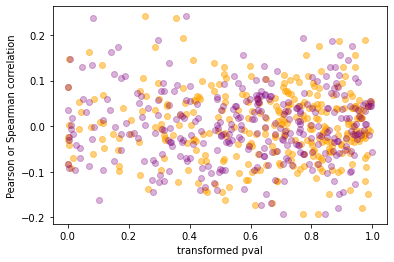

In [17]:
# # nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='ad', niter=50)
# # nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp_alt', niter=50)

# corr_avg = np.nanmean(corr_pearson_iter, axis=0)
# corr_avg = np.nanmean(corr_spearman_iter, axis=0)

# plt.scatter(p_anova**0.33, corr_avg, color='orange', alpha=0.5)
# plt.scatter(p_kruskal**0.33, corr_avg, color='purple', alpha=0.3)
# # plt.scatter(np.sqrt(p_anova), corr_avg, color='orange', alpha=0.5)
# # # plt.scatter(np.sqrt(p_kruskal), corr_avg, color='purple', alpha=0.3)

# plt.xlabel('transformed pval')
# plt.ylabel('Pearson or Spearman correlation');
# # plt.xlim(-0.01, 0.1);

## define vis driven & img driven

In [16]:
# # visually driven cells: pass (anova OR kruskal) AND amp threshold for >=1 image
# p_sig = 0.05
# vis_driven = ((p_anova < p_sig) | (p_kruskal < p_sig)) & (sum(evoked.T > 0.1) > 0).reshape(-1, 1)
# print(f'{vis_driven.sum()} cells are visually driven, \n\
#     proportion {np.round(vis_driven.sum()/ncell, 2)} out of {ncell} cells')

# # cells responsive to image i: pass visually driven (anova OR kruskal) AND t-test AND amp threshold for *this* image
# img_driven = vis_driven & (p_ttest < p_sig) & (evoked > 0.1)
# print(f'{img_driven.sum()} cells are image driven - with overlap between images, \n\
#     proportion {np.round(img_driven.sum() / (ncell*nstim), 2)} out of {ncell*nstim} cell-stim combos. \n\
#     1-30 image evokes resp from {np.sum(img_driven, axis=0)} cells')

# t = np.sum(img_driven, axis=1)
# print(f'img driven cells are driven by {t[t>0]} images')

159 cells are visually driven, 
    proportion 0.62 out of 256 cells
129 cells are image driven - with overlap between images, 
    proportion 0.02 out of 7680 cell-stim combos. 
    1-30 image evokes resp from [ 3  4  4  4  2  8  7  0  3  2  4  2  0  2 13  4  0  9  9  7  1  7  5  4
  3  4  7  5  3  3] cells
img driven cells are driven by [1 1 5 5 2 1 1 2 3 6 4 1 1 1 1 2 3 3 1 4 1 3 1 1 6 1 1 1 2 4 2 2 1 1 1 1 4
 6 5 1 2 1 6 2 6 1 4 1 1 2 5 1 1 1 2] images


In [11]:
# test whether subtracting baseline: yes

dfof_ad = np.empty((ncell, nstim))
dfof_tg = np.empty((ncell, nstim))
adp = np.empty((ncell, nstim))

for icell in np.arange(ncell):
    for istim in np.arange(nstim):
        dfof_ad[icell,istim] = np.mean(dfof_ad_trial[icell,istim])
        dfof_tg[icell,istim] = np.mean(dfof_tg_trial[icell,istim])
        adp[icell,istim] = (dfof_tg[icell,istim] - dfof_ad[icell,istim]) / (dfof_tg[icell,istim] + dfof_ad[icell,istim] + 1e-7)

adp[np.abs(adp) > 10] = np.nan
np.nanmean(adp), np.nanmedian(adp)

(-0.12964969176613583, -0.13930193442772637)

In [18]:
# vis_driven_mask = vis_driven.copy().astype(float).flatten() # apply vis driven mask -> non-vis cells = nan
# vis_driven_mask[vis_driven_mask==0] = np.nan

# img_driven_mask = img_driven.copy().astype(float)
# img_driven_mask[img_driven_mask==0] = np.nan

# # any_img_driven = np.sum(img_driven, axis=1)
# # any_img_driven[any_img_driven==0] = np.nan

# # print(vis_driven_mask.shape, img_driven_mask.shape, any_img_driven.shape)

In [22]:
# any_img_driven = np.sum(img_driven, axis=1)
# any_img_driven = (any_img_driven>0).astype(float)
# any_img_driven[any_img_driven==0] = np.nan
# np.nansum(any_img_driven)

55.0

# split side A/B bootstrap

## adp

In [35]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp', niter=100)

# nstim_shared_adp = nstim_shared_iter.copy()
# corr_pearson_adp = corr_pearson_iter.copy()
# p_pearson_adp = p_pearson_iter.copy()
# corr_spearman_adp = corr_spearman_iter.copy()

# nstim_shared_iter = nstim_shared_adp
# corr_pearson_iter = corr_pearson_adp
# p_pearson_iter = p_pearson_adp
# corr_spearman_iter = corr_spearman_adp

100%|██████████| 100/100 [02:33<00:00,  1.53s/it]


0.0

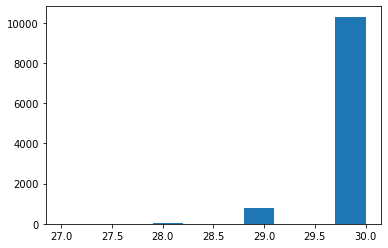

In [36]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


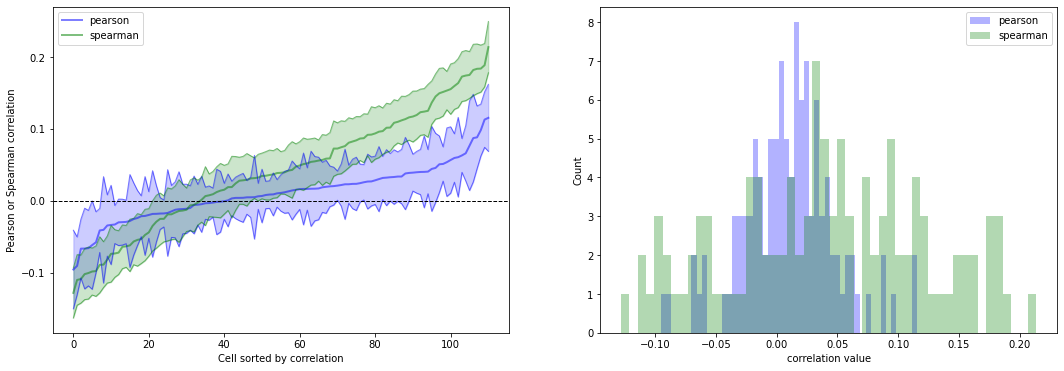

In [37]:
plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

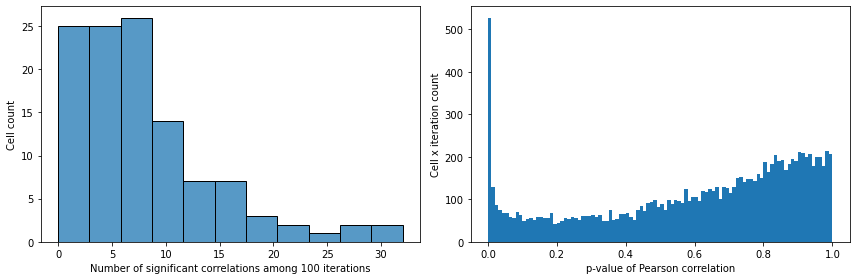

In [44]:
niter = 100

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

plt.subplot(1, 2, 2)
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
plt.tight_layout()

# sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## adp alt

In [10]:
nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp_alt', niter=100)

nstim_shared_adp_alt = nstim_shared_iter.copy()
corr_pearson_adp_alt = corr_pearson_iter.copy()
p_pearson_adp_alt = p_pearson_iter.copy()
corr_spearman_adp_alt = corr_spearman_iter.copy()

nstim_shared_iter = nstim_shared_adp_alt
corr_pearson_iter = corr_pearson_adp_alt
p_pearson_iter = p_pearson_adp_alt
corr_spearman_iter = corr_spearman_adp_alt

100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


0.0

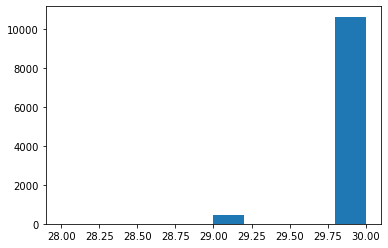

In [11]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\ll357\AppData\Local\Temp\10\ipykernel_38188\3201651895.py:1: RuntimeWarning: Mean of empty slice
  corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
C:\Users\ll357\AppData\Local\Temp\10\ipykernel_38188\3201651895.py:2: RuntimeWarning: Mean of empty slice
  corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
C:\Users\ll357\AppData\Local\Temp\10\ipykernel_38188\1612427013.py:48: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a, axis=0)


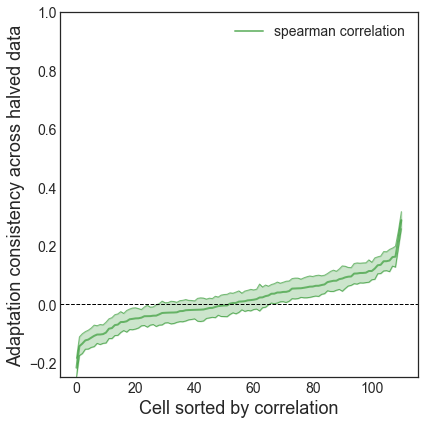

<Figure size 432x288 with 0 Axes>

In [30]:
corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.style.use('seaborn-white')
fig1 = plt.figure(figsize=(6,6))
# plt.subplot(121)
# plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson correlation')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman correlation')

# plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
# plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
# plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylim(-0.25, 1)
plt.xlabel('Cell sorted by correlation', fontsize=18)
plt.ylabel('Adaptation consistency across halved data', fontsize=18)

# set x & y tick font size
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.legend(fontsize=14);

plt.tight_layout()
plt.show()
plt.draw()
figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
# fig1.savefig(os.path.join(figpath, 'adp_consistency.pdf'), format='pdf')

# plt.subplot(122)
# plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
# plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
# plt.xlabel('correlation value')
# plt.ylabel('Count')
# plt.legend();

In [71]:
corr_max_id = np.nanargmax(corr_spearman_avg)
corr_0_id = np.nanargmin(np.abs(corr_spearman_avg)) # get id where corr_spearman_avg is closest to 0
corr_min_id = np.nanargmin(corr_spearman_avg)

peek_cell_id = [corr_min_id, corr_0_id, corr_max_id]
print(corr_spearman_avg[peek_cell_id])

adp_agg_sideA_pop, adp_agg_sideB_pop, corr_spearman_pop = split_correlate_side_peek_cell('adp_alt', peek_cell_id, niter=1)
len(adp_agg_sideA_pop), adp_agg_sideA_pop[0].shape, corr_spearman_pop.__len__()

[-0.21728978  0.00211521  0.28754457]


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


(3, (25,), 3)

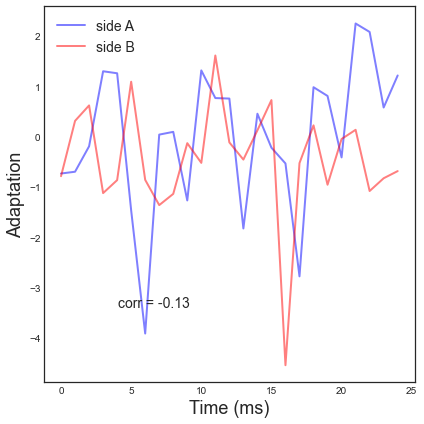

<Figure size 432x288 with 0 Axes>

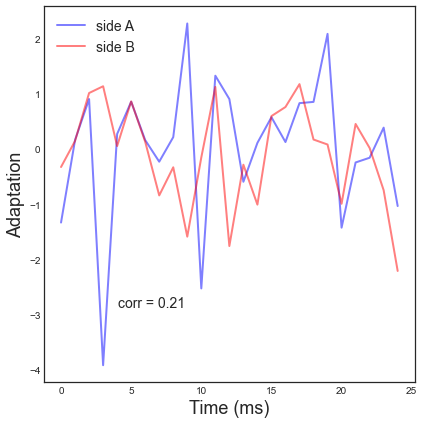

<Figure size 432x288 with 0 Axes>

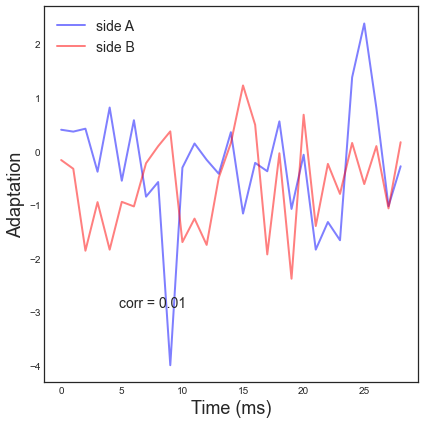

<Figure size 432x288 with 0 Axes>

In [72]:
# plot inset: lineplot for neuron with highest correlation, 0 correlation, and lowest correlation

for icell in np.arange(len(peek_cell_id)):
    fig2 = plt.figure(figsize=(6,6))
    plt.plot(adp_agg_sideA_pop[icell], color='blue', alpha=0.5, linewidth=2, label='side A')
    plt.plot(adp_agg_sideB_pop[icell], color='red', alpha=0.5, linewidth=2, label='side B')

    text = 'corr = ' + str(np.round(corr_spearman_pop[icell], 2))
    plt.text(0.2, 0.2, text, fontsize=14, transform=plt.gca().transAxes)

    plt.xlabel('Time (ms)', fontsize=18)
    plt.ylabel('Adaptation', fontsize=18)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.draw()
    figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
    # fig2.savefig(os.path.join(figpath, 'adp_consistency_{}.pdf'.format(icell)), format='pdf')

0.0887719298245614

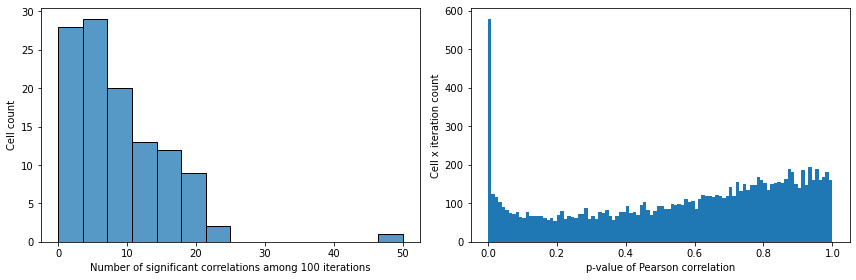

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
niter = 100
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

plt.subplot(1, 2, 2)
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
plt.tight_layout()

sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## adp stable

In [34]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp_stable', niter=100)

# nstim_shared_adp_stable = nstim_shared_iter.copy()
# corr_pearson_adp_stable = corr_pearson_iter.copy()
# p_pearson_adp_stable = p_pearson_iter.copy()
# corr_spearman_adp_stable = corr_spearman_iter.copy()

# # nstim_shared_iter = nstim_shared_adp_stable
# # corr_pearson_iter = corr_pearson_adp_stable
# # p_pearson_iter = p_pearson_adp_stable
# # corr_spearman_iter = corr_spearman_adp_stable

100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


6.451612903225807e-05

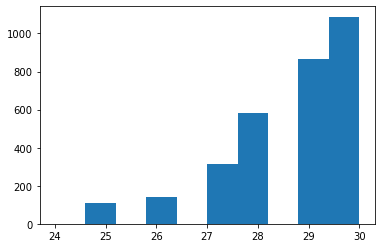

In [35]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


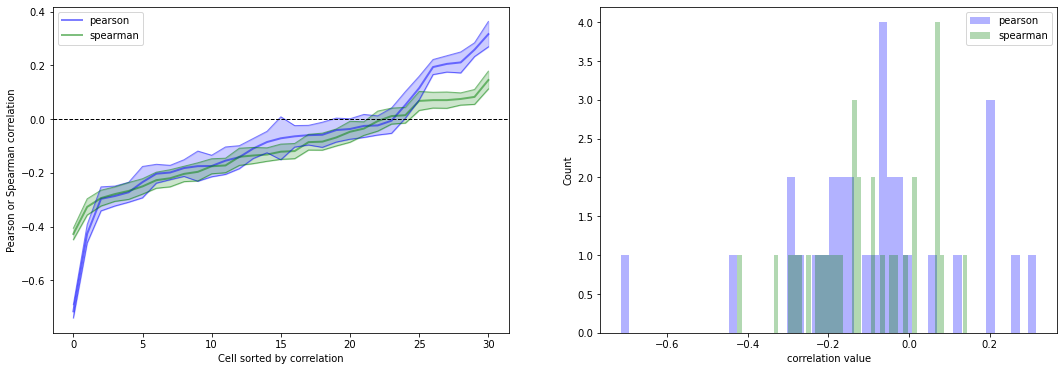

In [36]:
plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

# todo: why is corr of adp_stable mostly negative? bc R1 (both side) is negative & (R2 - R1) is positive???

NameError: name 'niter' is not defined

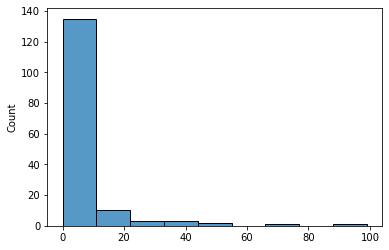

In [37]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

plt.subplot(1, 2, 2)
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
plt.tight_layout()

sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

0.0556640625

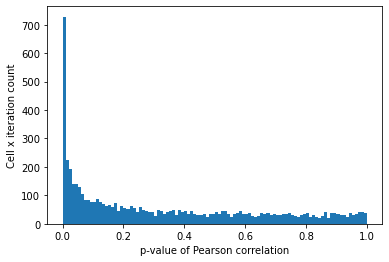

In [ ]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## resp ad

In [27]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='ad', niter=100)

# nstim_shared_resp_ad = nstim_shared_iter.copy()
# corr_pearson_resp_ad = corr_pearson_iter.copy()
# p_pearson_resp_ad = p_pearson_iter.copy()
# corr_spearman_resp_ad = corr_spearman_iter.copy()

nstim_shared_iter = nstim_shared_resp_ad
corr_pearson_iter = corr_pearson_resp_ad
p_pearson_iter = p_pearson_resp_ad
corr_spearman_iter = corr_spearman_resp_ad

0.0

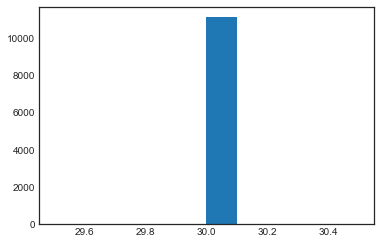

In [28]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\ll357\AppData\Local\Temp\4\ipykernel_16908\2856368228.py:1: RuntimeWarning: Mean of empty slice
  corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
C:\Users\ll357\AppData\Local\Temp\4\ipykernel_16908\2856368228.py:2: RuntimeWarning: Mean of empty slice
  corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
C:\Users\ll357\AppData\Local\Temp\4\ipykernel_16908\591368614.py:4: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a, axis=0)


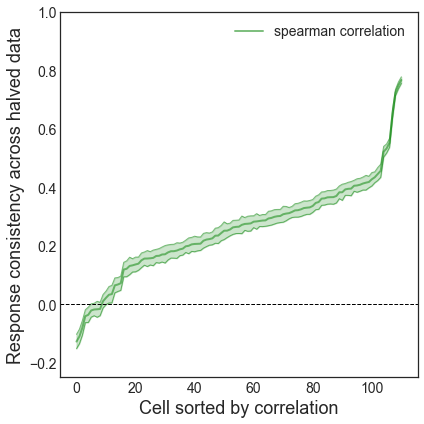

<Figure size 432x288 with 0 Axes>

In [29]:
corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.style.use('seaborn-white')
fig1 = plt.figure(figsize=(6,6))
# plt.subplot(121)
# plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson correlation')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman correlation')

# plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
# plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
# plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylim(-0.25, 1)
plt.xlabel('Cell sorted by correlation', fontsize=18)
plt.ylabel('Response consistency across halved data', fontsize=18)

# set x & y tick font size
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.legend(fontsize=14);

plt.tight_layout()
plt.show()
plt.draw()
figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
fig1.savefig(os.path.join(figpath, 'resp_consistency.pdf'), format='pdf')

# plt.subplot(122)
# plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
# plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
# plt.xlabel('correlation value')
# plt.ylabel('Count')
# plt.legend();

0.3307894736842105

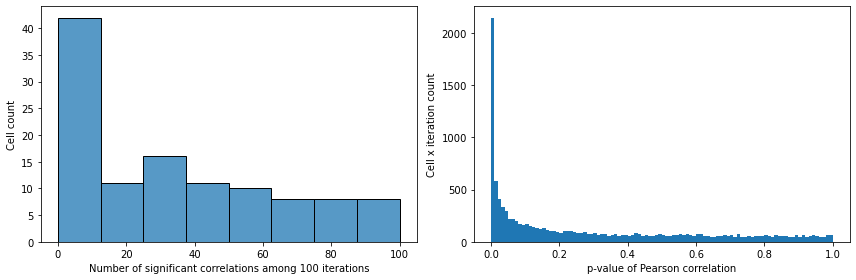

In [53]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

plt.subplot(1, 2, 2)
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
plt.tight_layout()

sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## resp tg

In [54]:
nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='tg', niter=100)

nstim_shared_resp_tg = nstim_shared_iter.copy()
corr_pearson_resp_tg = corr_pearson_iter.copy()
p_pearson_resp_tg = p_pearson_iter.copy()
corr_spearman_resp_tg = corr_spearman_iter.copy()

nstim_shared_iter = nstim_shared_resp_tg
corr_pearson_iter = corr_pearson_resp_tg
p_pearson_iter = p_pearson_resp_tg
corr_spearman_iter = corr_spearman_resp_tg

100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


0.0

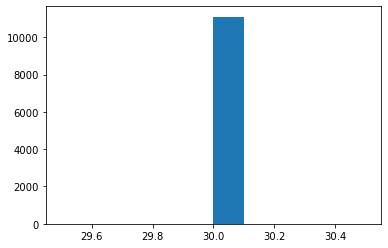

In [55]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


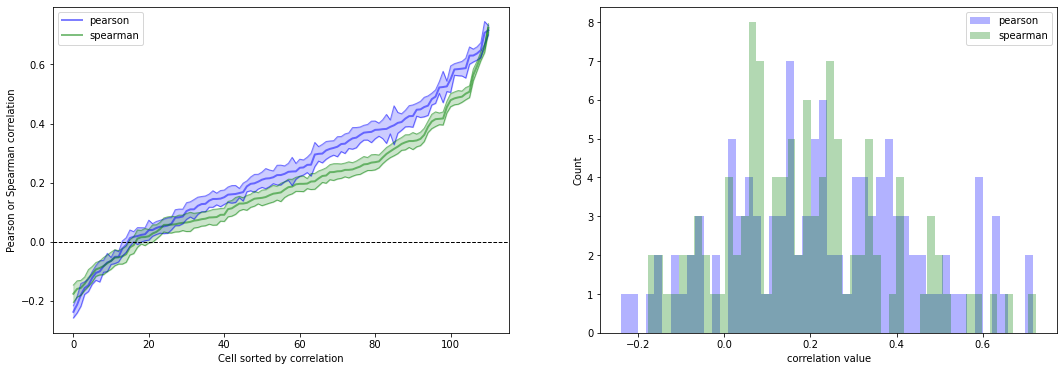

In [56]:
plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

0.3250877192982456

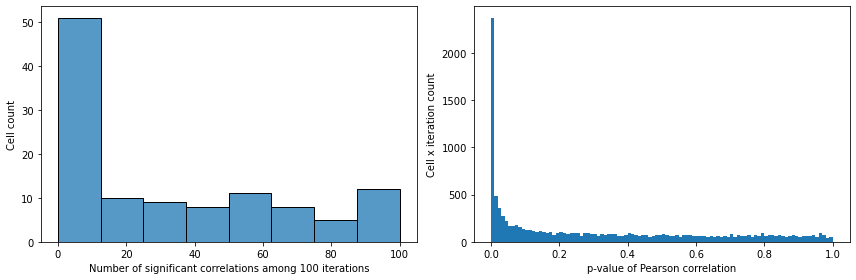

In [57]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

plt.subplot(1, 2, 2)
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
plt.tight_layout()

sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## save

In [342]:
# # save variable with pickle
# with open('split_corr.pickle', 'wb') as f:
#     pickle.dump(nstim_shared_adp, f)
#     pickle.dump(corr_pearson_adp, f)
#     pickle.dump(p_pearson_adp, f)
#     pickle.dump(corr_spearman_adp, f)

#     pickle.dump(nstim_shared_adp_alt, f)
#     pickle.dump(corr_pearson_adp_alt, f)
#     pickle.dump(p_pearson_adp_alt, f)
#     pickle.dump(corr_spearman_adp_alt, f)
    
#     pickle.dump(nstim_shared_resp_ad, f)
#     pickle.dump(corr_pearson_resp_ad, f)
#     pickle.dump(p_pearson_resp_ad, f)
#     pickle.dump(corr_spearman_resp_ad, f)

#     pickle.dump(nstim_shared_resp_tg, f)
#     pickle.dump(corr_pearson_resp_tg, f)
#     pickle.dump(p_pearson_resp_tg, f)
#     pickle.dump(corr_spearman_resp_tg, f)

# high corr ad only
use high corr ad cells to plot corr adp_alt  
or use high SNR cells (std/mean) # todo

[0.17722296 0.18017327 0.18245974 0.1914626  0.19360073 0.19502286
 0.21188995 0.21190076 0.21377292 0.22875599 0.23710692 0.23725177
 0.23908943 0.24185827 0.24566357 0.24716214 0.25098162 0.266394
 0.26648456 0.26682196 0.27058008 0.27828251 0.27947831 0.28542989
 0.28941774 0.28947338 0.29196504 0.29322517 0.29391414 0.29801301
 0.30075837 0.30354886 0.30543435 0.31121649 0.31143807 0.31480371
 0.32779326 0.33324031 0.33422506 0.34013821 0.34414095 0.34504788
 0.35278378 0.35820278 0.36034788 0.360812   0.36349112 0.36362663
 0.36822147 0.37441552 0.37651371 0.37814927 0.37938456 0.38478218
 0.38532272 0.39438263 0.39678311 0.40071246 0.4079763  0.40800667
 0.44610668 0.45618186 0.45932078 0.45973397 0.47581212 0.48913517
 0.49178999 0.50575959 0.51491498 0.52612784 0.53826992 0.55640347
 0.56017993 0.56351378 0.6892702  0.72017599 0.7649808 ]
[  0   2   3   4   6   8   9  10  11  12  13  14  16  17  18  21  23  25
  27  28  29  30  31  33  35  36  39  40  41  44  46  47  49  50  51

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


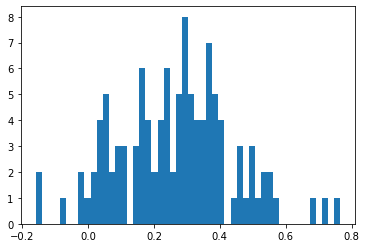

In [61]:
# nstim_shared_iter = nstim_shared_resp_ad
# corr_pearson_iter = corr_pearson_resp_ad
# p_pearson_iter = p_pearson_resp_ad
# corr_spearman_iter = corr_spearman_resp_ad

# corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
# corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)

# plt.hist(corr_pearson_avg, 50);
# corr_cutoff = np.percentile(corr_pearson_avg[~np.isnan(corr_pearson_avg)], 30) # find top percentile of corr ad
# print(np.sort(corr_pearson_avg[corr_pearson_avg>corr_cutoff]))

# cell_id_high_corr = np.where(corr_pearson_avg>corr_cutoff)[0]
# print(cell_id_high_corr)

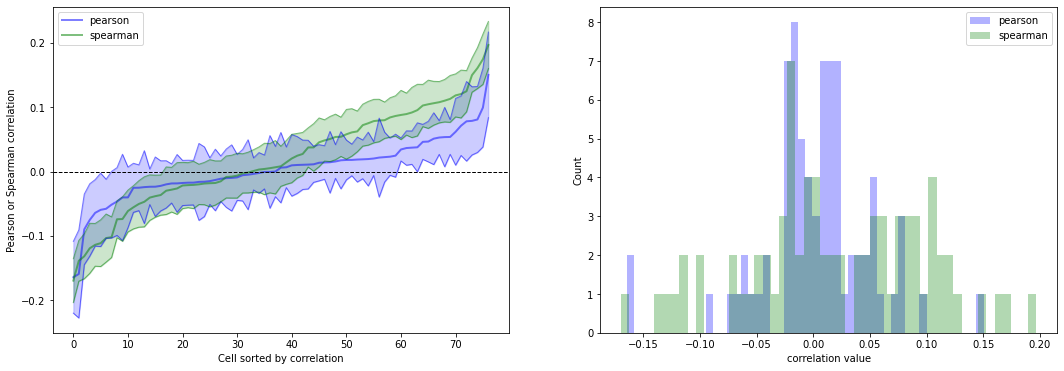

In [62]:
corr_pearson_iter = corr_pearson_adp_alt
corr_spearman_iter = corr_spearman_adp_alt
corr_pearson_iter = corr_pearson_iter[:, cell_id_high_corr]
corr_spearman_iter = corr_spearman_iter[:, cell_id_high_corr]

plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(len(cell_id_high_corr)), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(len(cell_id_high_corr)), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(len(cell_id_high_corr)), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(len(cell_id_high_corr)), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(len(cell_id_high_corr)), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(len(cell_id_high_corr)), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(len(cell_id_high_corr)), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(len(cell_id_high_corr)), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

# cirvar vs corr (resp or adp)
is it fair to use cirvar? there is no order in 30 imgs  
use OSI-like var? (max-min) / (sum_all)

In [254]:
# dfof_trial_avg = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
# selectivity_index = np.pi * np.ones((ncell, 1))
# resp_sum = np.sum(dfof_trial_avg['dfof_ad'], axis=1)

# for icell in np.arange(ncell):
#     resp_ad_cell = dfof_trial_avg['dfof_ad'][icell, :]
#     if np.max(resp_ad_cell) > 0:
#         selectivity_index[icell] = (np.max(resp_ad_cell) - np.min(resp_ad_cell)) / (np.max(resp_ad_cell) + np.min(resp_ad_cell)) #np.sum(resp_ad_cell)
#     else:
#         selectivity_index[icell] = np.nan
# selectivity_index.shape

(324, 1)

In [97]:
def log_flexible(x):
    res = x.copy()
    res_min = np.min(res)
    res = res + np.abs(res_min) + 1e-6
    res = np.log(res)

    # res[res<0] = -np.log(-res[res<0])
    # res[res>0] = np.log(res[res>0])
    return res

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


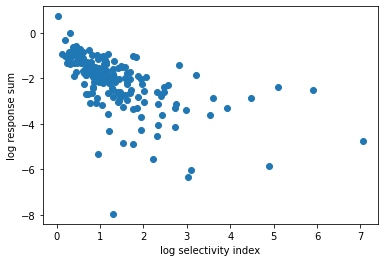

In [104]:
plt.scatter(np.log(selectivity_index), np.log(resp_sum)) # not including negative values
plt.xlabel('log selectivity index')
plt.ylabel('log response sum');
# plt.xlim(-0,10)
# plt.ylim(-4,1.5)

In [255]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp_alt', niter=50)

nstim_shared_iter = nstim_shared_adp_alt
corr_pearson_iter = corr_pearson_adp_alt
p_pearson_iter = p_pearson_adp_alt
corr_spearman_iter = corr_spearman_adp_alt

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)

selectivity_index.min(), selectivity_index.max(), corr_pearson_avg[np.argmin(selectivity_index)]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


(-586.5623629091054, 1149.3433033837082, nan)

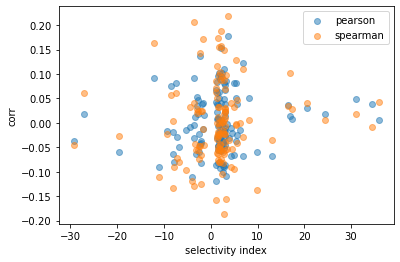

In [89]:
plt.scatter((selectivity_index), (corr_pearson_avg), label='pearson', alpha=0.5)
plt.scatter((selectivity_index), (corr_spearman_avg), label='spearman', alpha=0.5)

# plt.xscale('log') # set log scale for x axis
plt.xlabel('selectivity index')
plt.ylabel('corr')
plt.legend();

# visliz neuron trace  

In [150]:
# trace = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
# trace_vis = []
# for icell in np.arange(ncell):
#     trace_cell = trace['trace_avg'][icell]
#     if vis_driven[icell]:
#         trace_vis.append(trace_cell)
# trace_vis = np.array(trace_vis)

# # compare btw stim
# trace_mean = np.mean(trace_vis, axis=0)
# trace_std = np.std(trace_vis, axis=0)
# trace_sem = trace_std / np.sqrt(trace_vis.shape[0])
# trace_mean.shape

(30, 143)

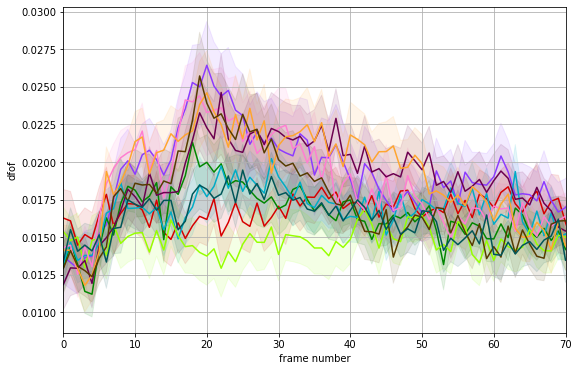

In [153]:
fig, ax = plt.subplots(figsize=(9,6))
long_palette = sns.color_palette(cc.glasbey, n_colors=30)
for istim in np.arange(0, 10):
    ax.plot(np.arange(trace_mean.shape[-1]), trace_mean[istim,:].flatten(), 
            color=long_palette[istim])
    
    ax.fill_between(np.arange(trace_mean.shape[-1]), 
                    trace_mean[istim,:].flatten() + trace_sem[istim,:].flatten(), 
                    trace_mean[istim,:].flatten() - trace_sem[istim,:].flatten(),
                    color=long_palette[istim], alpha=0.1)
plt.grid('minor')
plt.xlim(0,70)
plt.xlabel('frame number')
plt.ylabel('dfof')
# plt.legend(['inf', '750', '250'])
plt.show()

In [172]:
# trace_img = np.zeros((1, trace_mean.shape[1]))
# for icell in np.arange(ncell):
#     trace_cell = trace['trace_avg'][icell]
#     for istim in np.arange(nstim):
#         if img_driven[icell, istim]:
#             trace_img = np.vstack((trace_img, trace_cell[istim,:]))
#         else:
#             trace_img = np.vstack((trace_img, np.full(trace_cell[istim,:].shape, np.nan)))
#             # trace_img.append(np.full(trace_cell.shape, np.nan))
# # trace_img = np.array(trace_img)
# # trace_img.shape
# len(trace_img)


# #     if vis_driven[icell]:
# #         trace_img.append(trace_cell)

# # # compare btw stim
# # trace_mean = np.mean(trace_img, axis=0)
# # trace_std = np.std(trace_img, axis=0)
# # trace_sem = trace_std / np.sqrt(trace_img.shape[0])
# # trace_mean.shape

9721

# img driven split sideAB
## adp alt

100%|██████████| 100/100 [07:53<00:00,  4.74s/it]


(16643, 32400)

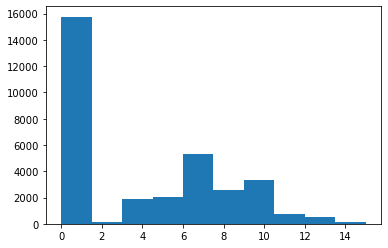

In [346]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side_img_driv(mode='adp_alt', niter=100)

# nstim_shared_adp_alt_img_driv = nstim_shared_iter.copy()
# corr_pearson_adp_alt_img_driv = corr_pearson_iter.copy()
# p_pearson_adp_alt_img_driv = p_pearson_iter.copy()
# corr_spearman_adp_alt_img_driv = corr_spearman_iter.copy()

# plt.hist(nstim_shared_iter.flatten());
# np.sum(nstim_shared_iter.flatten()>=2), corr_pearson_iter.shape[0]*corr_pearson_iter.shape[1]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


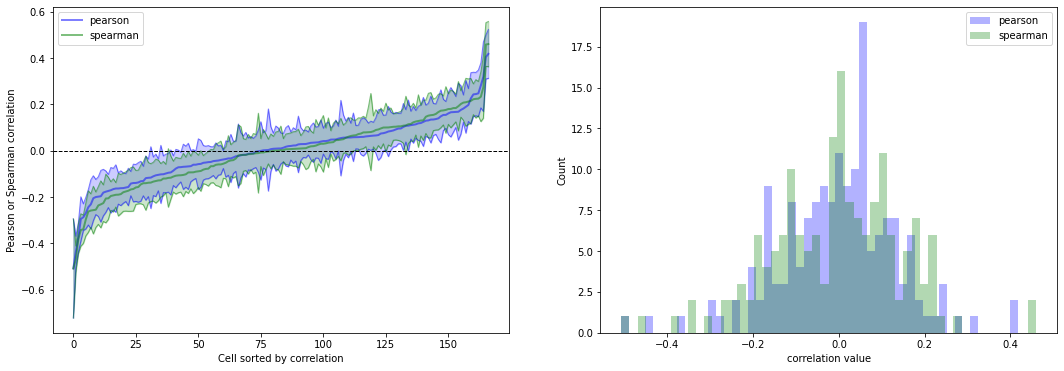

In [338]:
plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

0.03145061728395062

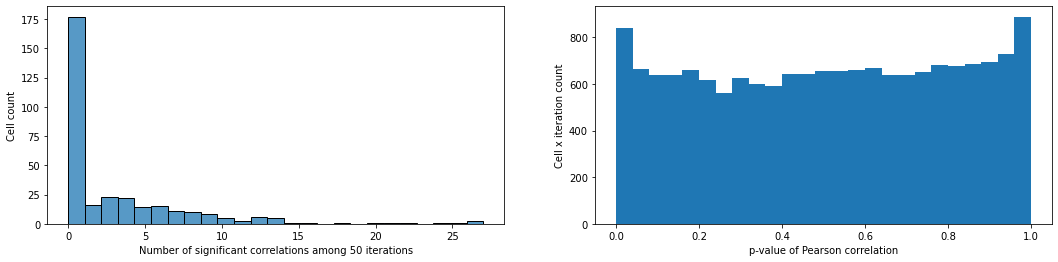

In [339]:
plt.figure(figsize=(18,4))
plt.subplot(121)
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig, bins=25);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

plt.subplot(122)
plt.hist(p_pearson_iter.flatten(), 25);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## ad

100%|██████████| 50/50 [05:02<00:00,  6.04s/it]


(8350, (50, 324))

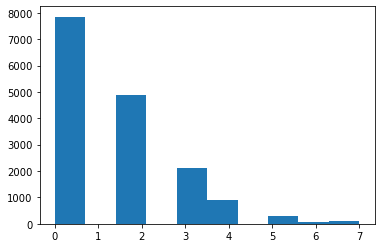

In [247]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side_img_driv(mode='ad', niter=100)

# plt.hist(nstim_shared_iter.flatten());
# np.sum(nstim_shared_iter.flatten()>=2), corr_pearson_iter.shape

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


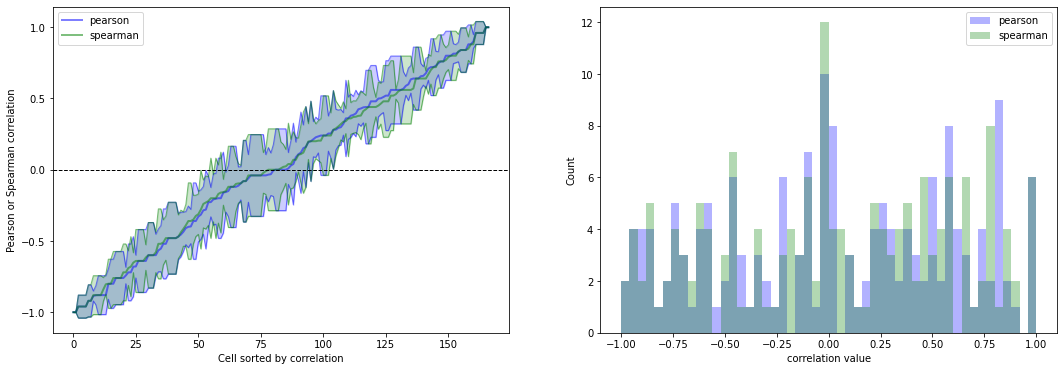

In [250]:
plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

0.010925925925925926

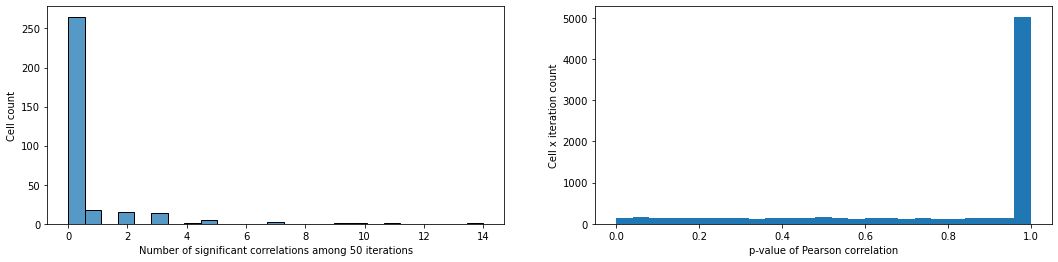

In [251]:
plt.figure(figsize=(18,4))
plt.subplot(121)
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig, bins=25);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

plt.subplot(122)
plt.hist(p_pearson_iter.flatten(), 25);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

# pairwise corr
from yuansi

In [ ]:
# # put everything into a numpy array
# # 256 is the number of cells, 30 is the number of stimuli, 34 is the number of repeats (or trials),
# dfof_ad_trial_flat = np.zeros((dfof_ad_trial.shape[0], dfof_ad_trial.shape[1], dfof_ad_trial[0, 0].shape[0]))

# ncell = dfof_ad_trial.shape[0] # 256
# nstim = dfof_ad_trial.shape[1] # 30
# ntrials = dfof_ad_trial[0, 0].shape[0] # 34

# for i in range(dfof_ad_trial.shape[0]):
#     for j in range(dfof_ad_trial.shape[1]):
#         dfof_ad_trial_flat[i, j, :] = dfof_ad_trial[i, j].reshape(-1)[:34]

# # get pairwise correlation
# def get_avg_corr(cell_index):
#     avg_corr = 0
#     nb_pairs = 0
#     for i in range(ntrials):
#         for j in range(i+1, ntrials):
#             curr_corr = np.corrcoef(dfof_ad_trial_flat[cell_index, :, i], dfof_ad_trial_flat[cell_index, :, j])
#             avg_corr += curr_corr
#             nb_pairs += 1
#     avg_corr = avg_corr/nb_pairs 
    
#     print("cell", '{:3d}'.format(cell_index), "avg corr", '{:.3f}'.format(avg_corr[0, 1]))
#     return avg_corr[0, 1]


# avg_corr_all = np.zeros(ncell)
# for i in range(ncell):
#     avg_corr_all[i] = get_avg_corr(i)

# # get top 20 cells with top pairwise correlation
# top20cells = np.argsort(avg_corr_all)[::-1][:20]
# # get their pairwise correlation
# avg_corr_all[top20cells]
# # repeat the same for caiman vs manual, 
# # and one will see that the difference in top pairwise correlation, and also in traces of the top cells